### Maxwell A. Fine 14880725
### Assingment 2: Stastical Methods in Astrophysics

In [110]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.stats import pearsonr, spearmanr
from itertools import combinations # fancy nested for loop
from scipy.stats import norm
from scipy.stats import lognorm
import scipy.stats as sps
import scipy.integrate as spint
 

# Set a seed for reproducibility
random_seed = 42

# Gaia correction term
gaia_corr = 0.029

### Initial Setup
First, load in the stars data as shown in Assignment 1, and create a dataframe containing only stars with Prob > 0.8, which you will use for the remainder of this assignment.

In [2]:
dr3stars = fits.open('gaiadr3_cluster_stars.fits')
dr3stars.info()
print(dr3stars[1].columns)
stars = pd.DataFrame(dr3stars[1].data)
stars['Name'] = stars['Name'].str.strip()
stars = stars[stars['Prob']>0.8]
clcounts = stars.groupby(['Name']).size().reset_index(name='count') 

Filename: gaiadr3_cluster_stars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  members.dat    1 TableHDU       331   1291929R x 56C   [A20, I4, I19, I1, F10.8, F12.8, F10.8, F12.8, F10.8, F12.8, E11.4, E11.4, F10.8, E11.4, F10.8, E11.4, F10.8, F11.8, F11.8, E11.4, E11.4, E11.4, E11.4, E11.4, E11.4, I2, F12.8, F10.7, F11.8, F10.8, F19.8, F16.8, F18.8, F17.8, F18.8, F17.8, F10.7, F10.7, F10.7, E11.4, E11.4, E11.4, E9.3, F12.8, F4.1, F6.1, F5.1, F11.7, F11.8, F6.1, F12.7, F13.8, F5.1, A13, I1, I1]   
ColDefs(
    name = 'Name'; format = 'A20'; start = 1
    name = 'ID'; format = 'I4'; disp = 'I4'; start = 22
    name = 'GaiaDR3'; format = 'I19'; disp = 'I19'; start = 27
    name = 'inrt'; format = 'I1'; disp = 'I1'; start = 47
    name = 'Prob'; format = 'F10.8'; disp = 'F10.8'; start = 49
    name = 'RAdeg'; format = 'F12.8'; unit = 'deg'; disp = 'F12.8'; start = 60
    name = 'e_RAdeg'; format = 'F10.8'; unit = 

### Task 1:
Use your stars dataframe to calculate the following 6 sample quantities per cluster: 
- the number of
stars in the cluster �∗; 
- the mean parallax, �$, of the stars in the cluster;
- the standard deviation �& of
the parallax of the stars in the cluster;
- the ‘size’ of the cluster �pos calculated using the standard
deviation in RA and Dec position of the stars1
;
- the mean proper motion of the cluster stars �̅;
- the standard deviation of the proper motion of the cluster stars �- (which can be calculated by adding in quadrature the RA and dec proper motion standard deviations, i.e. the same as for �pos). 

To help you do this in Pandas, you can adapt the code you used for Assignment 1:
clusters_hiprob = stars_hiprob.groupby(['Name']).size().reset_index(name='n_star')
clusters_sd_hiprob = stars_hiprob.groupby(['Name']).std(numeric_only=True).reset_index()
where the .std method calculates the sample standard deviations for all numerical quantities in the
stars data frame grouped according to cluster name, and a similar method exists for the sample
mean. Those can then be used to add the required columns to the dataframe with �∗.


Now, select only the clusters which satisfy �∗ > 200, �pos < 1∘
and for these clusters plot the 5
astrometric quantities only (i.e. excluding �∗) in a scatter-matrix plot, to compare each pair of
quantities and show their histograms. Comment on whether there are any clear correlations revealed
by the scatter plots.


### Idea:
* We can use the pandas 'groupby' function to grab all the stars from a cluster and perform our operation
* Make a new pd to hold our resulting data
* Modify last weeks plotting code (write a function this time!) for our corner plot
* Name of 6 parameters 
    - 'count' : # Number of stars in the cluster
    - 'Plx' : # Parallax of the star
    - 'RAdeg' : #  RA in deg
    - 'pmra' : # proper motion of the star

### Assumptions
- N/A for this problem 

In [21]:
my_stars_plx = stars[stars['Name'] == 'vdBergh_92']['Plx']
my_stars_plx

1291586    0.8721
1291588    0.8907
1291591    0.8960
1291594    0.8100
1291595    0.8281
            ...  
1291922    0.8562
1291923    0.8714
1291924    0.8419
1291925    0.9300
1291928    0.8469
Name: Plx, Length: 166, dtype: float64

In [3]:
# Cell to calculate cluster stastics 
# Group by 'Name' and calculate the required quantities
cluster_stats = stars.groupby('Name').agg(
    num_stars=('Name', 'count'),  # Number of stars 
    mean_parallax=('Plx', 'mean'),  # Mean parallax
    std_parallax=('Plx', 'std'),  # STD parallax
    mean_proper_motion=('pmRA', 'mean'),  # Mean proper motion
)

# Mean Proper motion
# Quadrature sum of RA and dec to calculate proper motion
mean_pmRA = stars.groupby('Name')['pmRA'].agg('mean')
mean_pmDEC = stars.groupby('Name')['pmDE'].agg('mean') # Ugh why is the data using 'DE' not 'DEC'??
mean_proper_motion = (mean_pmRA**2 + mean_pmDEC**2)**0.5
cluster_stats['mean_proper_motion'] = mean_proper_motion

# Size
# Quadrature sum of RA and dec to calculate 'Size'
std_radeg = stars.groupby('Name')['RAdeg'].agg('std')
std_decdeg = stars.groupby('Name')['DEdeg'].agg('std') # Ugh why is the data using 'DE' not 'DEC'??
size = (std_radeg**2 + std_decdeg**2)**0.5
cluster_stats['cluster_size'] = size

# STD proper motion
# Quadrature sum of RA and dec proper motion standard deviations
std_pm_ra = stars.groupby('Name')['pmRA'].agg('std')
std_pm_dec = stars.groupby('Name')['pmDE'].agg('std')
std_proper_motion = (std_pm_ra**2 + std_pm_dec**2)**0.5

# Add the calculated standard deviation of proper motion to the cluster_stats DataFrame
cluster_stats['std_proper_motion'] = std_proper_motion

# Filter only keeping num_stars > 200 & cluster_size < 1 degree
filtered_cluster_stats = cluster_stats[(cluster_stats['num_stars'] > 200) & (cluster_stats['cluster_size'] < 1)]
print(filtered_cluster_stats)




             num_stars  mean_parallax  std_parallax  mean_proper_motion  \
Name                                                                      
BH_131             227       0.125637      0.046214            6.536827   
BH_140             338       0.190195      0.043486           14.897046   
BH_66              355       0.123089      0.044962            5.470541   
Berkeley_36        217       0.217359      0.065872            1.967901   
Berkeley_39        211       0.226982      0.038289            2.371439   
...                ...            ...           ...                 ...   
UBC_461            231       0.298768      0.031775            4.096675   
UBC_517            256       0.405671      0.022682            5.685520   
UBC_600            390       0.171171      0.039550            1.191558   
UFMG_2             212       0.377292      0.026794            5.382440   
UFMG_38            246       0.297418      0.053870            3.182825   

             cluster_siz

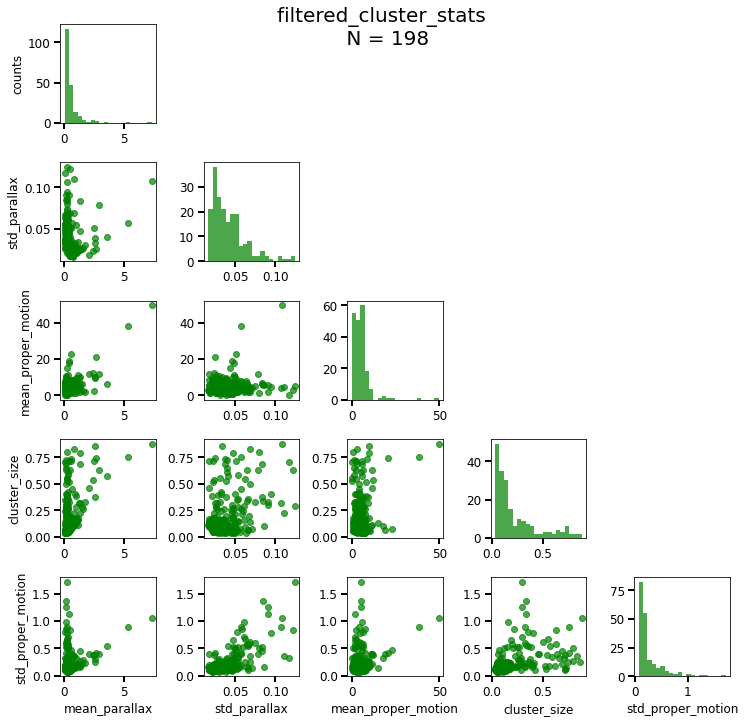

In [12]:
# Plotting cell

# Define labels and colors
labels = ['mean_parallax', 'std_parallax', 'mean_proper_motion', 'cluster_size', 'std_proper_motion']
ndims = len(labels)


# Nested for loop for plotting
fig, axes = plt.subplots(ndims, ndims, figsize=(12, 12))
fig.subplots_adjust(wspace=0.5, hspace=0.4)
plotting_df = filtered_cluster_stats

for i in range(ndims):  # y dimension of the grid
    for j in range(ndims):  # x dimension of the grid
        axes[i, j].tick_params(axis='both', which='major', labelsize=12, width=2, length=6)

        if i == j:
            axes[i, j].hist(plotting_df[labels[i]].values, bins=20, color='green', alpha=0.7)
        elif i > j:
            axes[i, j].scatter(plotting_df[labels[j]].values, plotting_df[labels[i]].values, color='green', alpha=0.7)
        else:
            axes[i, j].axis('off')

        if j == 0:
            if i == j:
                axes[i, j].set_ylabel('counts', fontsize=12)
            else:
                axes[i, j].set_ylabel(labels[i], fontsize=12)

        if i == ndims - 1:
            axes[i, j].set_xlabel(labels[j], fontsize=12)

plt.suptitle('filtered_cluster_stats \n N = ' + str(len(plotting_df[labels[i]].values)), size=20, y=0.9)
plt.show()

### 1 Comments:

Judging by the scatter matrix plot (aka the corner plot), there are some very clear correlations of different parameters. They do not appear as independent Guassians. However the indiivudal parameters do appear as  Gaussian distrubtions. 

### Add more comments



### Task 2 Correlation tests:

### A. 
Now search for correlations by calculating the Pearson and Spearman correlation coefficients
and p-values for each of the combinations shown in the scatter-matrix plots. Comment on
whether the tests are appropriate given the observed distributions of the measured
quantities.
### B. 
You can improve the situation by performing the tests on log-transformed data (i.e. on the
logarithm of the quantities instead of the original values). Why should this make the tests
more reliable? Finally, comment on your results and their implications.


In [11]:
# 2A
# Create an empty DataFrame to store the results
correlation_results_df = pd.DataFrame(columns=['Comparison', 'Pearson Coefficient',
                                               'Pearson P-Value', 'Spearman Coefficient', 'Spearman P-Value'])


# Calculate correlation coefficients and p-values
for label1, label2 in combinations(labels, 2): # Fancy nested for loop

    # Calculate Pearson correlation coefficient and p-value
    pearson_corr, pearson_p_value = pearsonr(filtered_cluster_stats[label1], filtered_cluster_stats[label2])

    # Calculate Spearman correlation coefficient and p-value
    spearman_corr, spearman_p_value = spearmanr(filtered_cluster_stats[label1], filtered_cluster_stats[label2])

    # Place results in pd, this is similar to a dict
    comparison_key = f'{label1} vs {label2}'
    correlation_results_df = pd.concat([
        correlation_results_df,
        pd.DataFrame({
            'Comparison': [comparison_key],
            'Pearson Coefficient': [pearson_corr],
            'Pearson P-Value': [pearson_p_value],
            'Spearman Coefficient': [spearman_corr],
            'Spearman P-Value': [spearman_p_value]
        })
    ], ignore_index=True)

# Printing it out like this looks much nicer
print('2A')
correlation_results_df

2A


/tmp/ipykernel_7281/2028896275.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results_df = pd.concat([


,Comparison,Pearson Coefficient,Pearson P-Value,Spearman Coefficient,Spearman P-Value
0,mean_parallax vs std_parallax,0.047611,5.053547e-01,-0.376186,4.712017e-08
1,mean_parallax vs mean_proper_motion,0.668548,5.222066e-27,0.051292,4.729721e-01
2,mean_parallax vs cluster_size,0.476555,1.275929e-12,0.373636,5.897056e-08
3,mean_parallax vs std_proper_motion,0.228468,1.206247e-03,0.025229,7.242273e-01
4,std_parallax vs mean_proper_motion,0.129134,6.980531e-02,-0.013398,8.513929e-01
5,std_parallax vs cluster_size,0.341305,8.621712e-07,0.208774,3.160198e-03
6,std_parallax vs std_proper_motion,0.713024,4.760937e-32,0.604036,4.484188e-21
7,mean_proper_motion vs cluster_size,0.236015,8.156744e-04,-0.005288,9.410603e-01
8,mean_proper_motion vs std_proper_motion,0.264974,1.615733e-04,0.153248,3.112366e-02
9,cluster_size vs std_proper_motion,0.403202,3.872148e-09,0.554065,2.508930e-17


In [10]:
# 2B log this time
# Create an empty DataFrame to store the results
log_correlation_results_df = pd.DataFrame(columns=['Comparison', 'Pearson Coefficient',
                                               'Pearson P-Value', 'Spearman Coefficient', 'Spearman P-Value'])


# Calculate correlation coefficients and p-values
for label1, label2 in combinations(labels, 2): # Fancy nested for loop

    # Calculate Pearson correlation coefficient and p-value
    pearson_corr, pearson_p_value = pearsonr(np.log10(filtered_cluster_stats[label1]), np.log10(filtered_cluster_stats[label2]))

    # Calculate Spearman correlation coefficient and p-value
    spearman_corr, spearman_p_value = spearmanr(np.log10(filtered_cluster_stats[label1]), np.log10(filtered_cluster_stats[label2]))

    # Place results in pd, this is similar to a dict
    comparison_key = f'{label1} vs {label2}'
    log_correlation_results_df = pd.concat([
        log_correlation_results_df,
        pd.DataFrame({
            'Comparison': [comparison_key],
            'Pearson Coefficient': [pearson_corr],
            'Pearson P-Value': [pearson_p_value],
            'Spearman Coefficient': [spearman_corr],
            'Spearman P-Value': [spearman_p_value]
        })
    ], ignore_index=True)


# Printing it out like this looks much nicer
print('2B')
log_correlation_results_df

2B


/tmp/ipykernel_7281/3359116749.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_correlation_results_df = pd.concat([


,Comparison,Pearson Coefficient,Pearson P-Value,Spearman Coefficient,Spearman P-Value
0,mean_parallax vs std_parallax,-0.252036,3.409650e-04,-0.376186,4.712017e-08
1,mean_parallax vs mean_proper_motion,0.196391,5.553836e-03,0.051292,4.729721e-01
2,mean_parallax vs cluster_size,0.428522,3.012242e-10,0.373636,5.897056e-08
3,mean_parallax vs std_proper_motion,0.111445,1.180250e-01,0.025229,7.242273e-01
4,std_parallax vs mean_proper_motion,-0.002964,9.669425e-01,-0.013398,8.513929e-01
5,std_parallax vs cluster_size,0.264515,1.660300e-04,0.208774,3.160198e-03
6,std_parallax vs std_proper_motion,0.673524,1.576212e-27,0.604036,4.484188e-21
7,mean_proper_motion vs cluster_size,-0.027338,7.022286e-01,-0.005288,9.410603e-01
8,mean_proper_motion vs std_proper_motion,0.169528,1.695536e-02,0.153248,3.112366e-02
9,cluster_size vs std_proper_motion,0.557149,1.535025e-17,0.554065,2.508930e-17


### 2 Comments:


### 3 Intro to Bayesian thinking:

Now randomly select a cluster from the sample used in Task 2. Using the parallaxes of the individual
stars in the cluster, use Bayes’ theorem to calculate the posterior pdf for the distance � (in kpc) to the
cluster, using the formula � = 1/� where � is the parallax in milliarcsec (mas). Gaia has a known
‘zero-point’ offset - a systematic error – in the parallax, so before you do your calculation you
should first add a correction of 0.029 mas to the parallax measurements. You should calculate the
posterior pdf for two different prior pdfs:

a. a uniform prior distrubution 

b. A more realistic pdf corresponding to constant volume density modified by an exponential
decrease with distance: p(d) ~ d^2 exp(-d/l), where L = 1kpc is a charastric length scale

You may assume that the corrected parallax measurements are normally distributed about the true
parallax, with standard deviation given by the errors on the parallax measurements. For each prior,
calculate the distance corresponding to the mode (maximum) of the posterior pdf, plot your posterior
pdf (on the same plot for both priors) and determine the 1-� confidence interval on the distance and
indicate the mode and interval on your pdf. Also on the same plot, compare the Bayesian posterior
pdfs with the pdf you obtain just by assuming the normal distribution with mean obtained by
inverting the mean parallax for the cluster, �$ (to obtain �) and standard deviation obtained by
propagating the standard error on �$, to obtain the standard deviation on �.
Finally, repeat the analysis above using just 10 stars from the cluster (you should pick a random subsample), to see the effect of smaller numbers.
Hint for fast numerical calculation: to output a pandas data column to a numpy array which you can
reshape as needed, use the .values method.

In [30]:
n_events = np.array([4,2,4,0,5,3,8,3])
my_stars_plx = stars[stars['Name'] == 'vdBergh_92']['Plx']
my_stars_plx
n_events = my_stars_plx + gaia_corr # add correction factor 

np.min(n_events)

0.029755800000000002

prior ()
likel_prior (1000,)
lam_array (1000,)


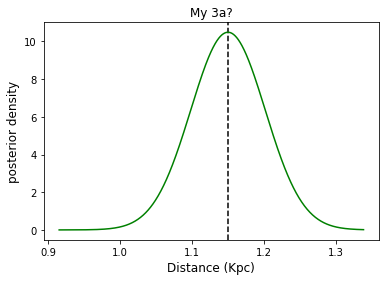

In [101]:
# Assuming my_stars_plx is your array of parallax values
my_stars_plx = stars[stars['Name'] == 'vdBergh_92']['Plx'].values
n_events = my_stars_plx + gaia_corr  # Adding correction factor

# Calculate mean and standard deviation from your data
mean_plx = np.mean(my_stars_plx)
std_plx = np.std(my_stars_plx)


# Create a grid of 1000 values of lambda to calculate the posterior over:
# lambda would be the true distance
dist_arr = np.linspace(0.95/np.max(n_events), 1.05/np.min(n_events) ,1000)

# Here we assume a uniform prior. The prior probability should integrate to 1, 
# although since the normalisation of the prior divides out of Bayes' formula it could have been arbitrary 
prior = 1    
'''
# This is the numerator in Bayes' formula, the likelihood multiplied by the prior. Note that we have to 
# reshape the events data array to be 2-dimensional, in the output array the 2nd dimension will 
# correspond to the lambda array values. Like np.sum, the numpy product function np.prod needs us to tell
# it which axis to take the product over (the data axis for the likelihood calculation)
likel_prior = np.prod(sps.poisson.pmf(n_events.reshape(len(n_events),1),mu=lam_array),axis=0)*prior

# We calculate the denominator (the "evidence") with one of the integration functions.
# The second parameter (x) is the array of parameter values we are integrating over.
# The axis is the axis of the array we integrate over (by default the last one but we will state 
# it explicitly as an argument here anyway, for clarity):
likel_prior_int = spint.simpson(likel_prior,lam_array,axis=0)



# Now we normalise and we have our posterior pdf for lambda!
posterior_pdf = likel_prior/likel_prior_int

'''
# Calculate the likelihood using a normal distribution
#n_events.reshape(len(n_events),1)
# likel_prior = np.prod(norm.pdf(lam_array, loc=1/mean_plx, scale=std_plx), axis=0) * prior

likel_prior = norm.pdf(dist_arr, loc=1/mean_plx, scale=std_plx)

print('prior', np.shape(prior))
print('likel_prior', np.shape(likel_prior))
print('lam_array', np.shape(lam_array))


# Calculate the evidence (denominator) using Simpson's rule
likel_prior_int = spint.simpson(likel_prior, lam_array, axis=0)

# Normalize to get the posterior PDF for lambda
posterior_pdf = likel_prior / likel_prior_int

# And plot it...
plt.figure()
plt.axvline(1/mean_plx, label='mean_plx', linestyle='--', color='k')
plt.plot(dist_arr, posterior_pdf, color='green')
plt.xlabel(r'Distance (Kpc)',fontsize=12)
plt.ylabel(r'posterior density',fontsize=12)
plt.title('My 3a?')
plt.savefig('max_3a',bbox_inches='tight')
plt.show()

In [113]:
# For this many measurements the posterior pdf will be much narrower - our previous lambda grid
# will be too coarse with the old range of lambda, we will need to zoom in to a smaller range:
# Assuming my_stars_plx is your array of parallax values
my_stars_plx = stars[stars['Name'] == 'vdBergh_92']['Plx'].values
n_events = my_stars_plx + gaia_corr  # Adding correction factor

# Calculate mean and standard deviation from your data
mean_plx = np.mean(my_stars_plx)
std_plx = np.std(my_stars_plx)


# Create a grid of 1000 values of lambda to calculate the posterior over:
# lambda would be the true distance
dist_arr = np.linspace(0.95/np.max(n_events), 1.05/np.min(n_events) ,1000)


prior = 1/20  
# We need to sum the individual log-likelihoods and also the log(prior):
loglikel_prior = np.sum(np.log(sps.poisson.pmf(n_events.reshape(len(n_events),1),
                                            mu=lam_array)),axis=0) + np.log(prior)

# We can shift the function maximum to zero in log units, i.e. unity in linear units.
# The shift is arbitrary, we just need to make the numbers manageable for the computer.
likel_prior = np.exp(loglikel_prior-np.amax(loglikel_prior))

likel_prior_int = spint.simpson(likel_prior,lam_array,axis=0)

print(likel_prior_int)
# Now we normalise and we have our posterior pdf for lambda!
posterior_pdf = likel_prior/likel_prior_int
# And plot it...
plt.figure()
plt.plot(lam_array,posterior_pdf)
plt.xlabel(r'$\lambda$',fontsize=12)
plt.ylabel(r'posterior density',fontsize=12)
plt.show()

TypeError: _parse_args() missing 1 required positional argument: 's'

1.4739327617934378e+155

0.00017003911324208864


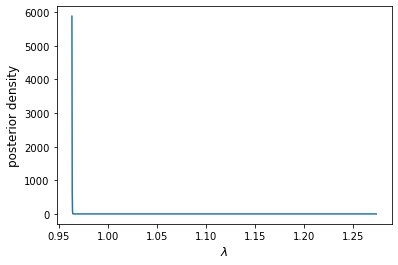

In [144]:
import numpy as np
import scipy.stats as sps
import scipy.integrate as spint
import matplotlib.pyplot as plt

# Assuming my_stars_plx is your array of parallax values
my_stars_plx = stars[stars['Name'] == 'vdBergh_92']['Plx'].values
n_events = my_stars_plx + gaia_corr  # Adding correction factor # 166

# Calculate mean and standard deviation from your data
mean_plx = np.mean(my_stars_plx)
std_plx = np.std(my_stars_plx)

# Create a grid of 1000 values of lambda to calculate the posterior over:
# lambda would be the true distance
dist_arr = np.linspace(1 / np.max(n_events), 1 / np.min(n_events), 1000)

# Set parameters for log-normal distribution
mu_ln = np.log(dist_arr) #np.log(n_events)
sigma_ln = np.std(np.log(my_stars_plx))

# Calculate log-likelihood for log-normal distribution
loglikel_ln = np.sum(sps.lognorm.pdf(n_events.reshape(len(n_events),1), s=sigma_ln, scale=np.exp(mu_ln)), axis=0)

# We can shift the function maximum to zero in log units, i.e. unity in linear units.
# The shift is arbitrary; we just need to make the numbers manageable for the computer.
likel_ln = np.exp(loglikel_ln - np.amax(loglikel_ln))

likel_ln_int = spint.simpson(likel_ln, dist_arr, axis=0)

print(likel_ln_int)

# Now we normalize and we have our posterior pdf for lambda!
posterior_pdf_ln = likel_ln / likel_ln_int

# And plot it...
plt.figure()
plt.plot(dist_arr, posterior_pdf_ln)
plt.xlabel(r'$\lambda$', fontsize=12)
plt.ylabel(r'posterior density', fontsize=12)
plt.savefig('3a_wip.pdf',bbox_inches='tight')
plt.show()

In [141]:
pwd

'/home/afinemax/afinemax/khazad-dum/school_2023_2024/stat_meth/assignments/a2'

In [134]:
np.shape(loglikel_ln)

(1000,)

In [130]:
np.shape(loglikel_ln )

(166,)

loglikel_prior (1000,)
likel_prior_int ()
0.04833777811320313


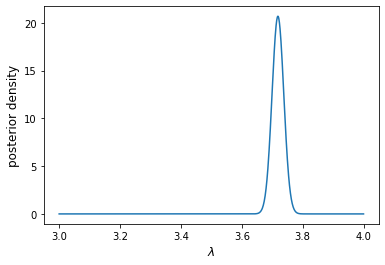

In [122]:
# For this many measurements the posterior pdf will be much narrower - our previous lambda grid
# will be too coarse with the old range of lambda, we will need to zoom in to a smaller range:
n_events = sps.poisson.rvs(mu=3.7,size=10000)
lam_array = np.linspace(3,4,1000)

prior = 1/20  
# We need to sum the individual log-likelihoods and also the log(prior):
loglikel_prior = np.sum(np.log(sps.poisson.pmf(n_events.reshape(len(n_events),1),
                                            mu=lam_array)),axis=0) + np.log(prior)

print('loglikel_prior', np.shape(loglikel_prior))

# We can shift the function maximum to zero in log units, i.e. unity in linear units.
# The shift is arbitrary, we just need to make the numbers manageable for the computer.
likel_prior = np.exp(loglikel_prior-np.amax(loglikel_prior))

likel_prior_int = spint.simpson(likel_prior,lam_array,axis=0)

print('likel_prior_int', np.shape('likel_prior_int'))

print(likel_prior_int)
# Now we normalise and we have our posterior pdf for lambda!
posterior_pdf = likel_prior/likel_prior_int
# And plot it...
plt.figure()
plt.plot(lam_array,posterior_pdf)
plt.xlabel(r'$\lambda$',fontsize=12)
plt.ylabel(r'posterior density',fontsize=12)
plt.show()